## Barrier Option Simulation

We consider the payoff of Lookback style options of the general form

$$h_T = f(X_T, \underset{t\in[0,T]}{sup} X_t \leq L)$$

and would like to compute

$$e^{-rT}\mathbb{E}(f(X_T, \underset{t\in[0,T]}{sup} X_t \leq L))$$



In [ ]:
import numpy as np
from typing import Tuple
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

In [ ]:
class asset:
    """
    Simulates asset paths under Black-Scholes and Heston models.

    Parameters:
        S0 (float): Initial asset price.
        T (float): Maturity in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility for Black-Scholes.
        kappa (float): Mean reversion rate in the Heston model.
        theta (float): Long-term variance in the Heston model.
        xi (float): Volatility of variance in the Heston model.
        v0 (float): Initial variance in the Heston model.
        rho (float): Correlation between asset and variance Brownian motions.

    Methods:
        black_and_scholes_paths (int, int) -> np.ndarray:
            Simulates Black-Scholes paths for the asset over given steps and simulations.

        heston_asset_paths (int, int) -> np.ndarray:
            Simulates asset paths under the Heston model for given steps and simulations.

        get_paths (int, str, str, int, int) -> np.ndarray:
            Retrieves asset paths based on the specified model (Black-Scholes or Heston).
    """

    def __init__(self, S0 = 100, T = 1, r = 0.05, sigma = 0.3, kappa = 1.0, theta = 0.04, xi = 0.1, v0 = 0.04, rho = -0.7):
        self.S0 = S0
        self.T = T
        self.r = r
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.v0 = v0
        self.rho = rho

    def black_and_scholes_paths(self, noise, n_steps = 252, n_simulations = 1000):
        """
        Simulates asset paths under the Black-Scholes model.

        Parameters:
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Simulated asset paths under Black-Scholes model.
        """
        delta = self.T / n_steps
        X = np.zeros((n_steps, n_simulations))
        X[0] = self.S0

        for t in range(1, n_steps):
            X[t] = X[t-1] + self.r * X[t-1] * delta + self.sigma * X[t-1] * np.sqrt(delta) * noise[t]

        return X

    def heston_asset_paths(self, noise, noise_X, n_steps = 252, n_simulations = 1000, end_value = False):
        """
        Simulates asset paths under the Heston model.

        Parameters:
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Simulated asset paths under the Heston model.
        """
        delta = self.T / n_steps
        noise_V = self.rho * noise_X + np.sqrt(1 - self.rho ** 2) * noise

        X = np.zeros((n_steps, n_simulations))
        V = np.zeros((n_steps, n_simulations))
        X[0] = self.S0
        V[0] = self.v0

        for t in range(1, n_steps):
            V[t] = np.maximum(V[t - 1] + self.kappa * (self.theta - V[t - 1]) * delta + self.xi * np.sqrt(V[t - 1]) * np.sqrt(delta) * noise_V[t], 0)
            X[t] = X[t-1] + self.r * X[t-1] * delta + np.sqrt(V[t-1]) * X[t-1] * np.sqrt(delta) * noise_X[t]

        return X

    def get_paths(self, noise, model = 'BS', n_steps = 252, n_simulations = 1000):
        """
        Retrieves paths based on specified model (Black-Scholes or Heston).

        Parameters:
            t (int): Time index for retrieving the asset path. Default is -1 (final time step).
            model (str): Model type ('BS' for Black-Scholes, 'heston' for Heston).
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Asset paths for the specified model and option type.
        """
        if model == 'BS':
              return self.black_and_scholes_paths(n_steps = n_steps, n_simulations = n_simulations, noise = noise)
        elif model == 'heston':
              return self.heston_asset_paths(n_steps = n_steps, n_simulations = n_simulations, noise = noise)
        else:
            raise ValueError("Incorrect model. Choose either 'BS' or 'heston'.")

## Simulate the joint variable $(\bar{X}_T^n, \underset{t \in [0,T]}{\sup} \bar{X}_T^n)$ on the Euler scheme

Due to the discretization of the process $\bar{X}_T^n$, simply taking the maximum observed value and checking whether it breaches the barrier leads to underestimating the option's value.

This underestimation occurs because there may be instances where the process should have breached the barrier, but the discretization failed to capture this due to the absence of a sampled point that crossed the barrier.

To account for this limitation, we need to compute the law of $\underset{t \in [0,T]}{\sup} \bar{X}_T^n$ which considers the supremum of the process over the entire interval.

We know that $
\mathscr{L}\left(\underset{t \in [0,T]}{\sup} \bar{X}_t^n \ \middle| \ X_{t_k} = x_k, \ k \in [0, n-1]\right) = \mathscr{L}\left(\underset{k \in [0, n - 1]}{\max} \bar{M}_{k,n}^{x_k, x_{k+1}}\right)
$

With $
\bar{M}_{k,n}^{x_k, x_{k+1}} = \underset{t \in \left[0, \frac{T}{n}\right]}{\sup} \left(x_k + \frac{t}{\frac{T}{n}}(x_{k+1} - x_k) + \sigma(t_k, x_k) Y_{t - t_k}^{W, \frac{T}{n}}\right)
$

and
$
Y_t^{W, T} = W_t - \frac{t}{T} W_T
$

Moreover we know that $
\mathbb{P}\left(\bar{M}_{k,n}^{x_k, x_{k+1}} \geq z\right) = e^{-\frac{2}{\frac{T}{n}} \frac{(z - x_k)(z - x_{k+1})}{\sigma^2(t_k, x_k)}} = u
$

Solving for $z$, we get
$
z_{\pm} = \frac{x_{k+1} + x_k \pm \sqrt{(x_{k+1} - x_k)^2 - \frac{2T}{n} \sigma^2(t_k, x_k) \ln{u}}}{2}
$

As we wish to satisfy $z \geq \min(x_{k+1}, x_k)$, we choose $z_{+}$, leading to $
\bar{M}_{k,n}^{x_k, x_{k+1}} = \bar{G}^n_{x_k, x_{k+1}}(U_k)
$ where $U_k \sim U([0,1])$.

Finally

$$
(\bar{X}_T^n, \underset{t \in [0,T]}{\sup} \bar{X}_T^n) \sim \left(\bar{X}_T^n, \underset{k \in [0, n - 1]}{\max} \bar{G}_{\bar{X}_{k}, \bar{X}_{k+1}}^n(U_k)\right)
$$

with $
\bar{G}_{x_{k-1}, x_k}^n(U_k) = \frac{x_{k-1} + x_k + \sqrt{(x_{k-1} - x_k)^2 - \frac{2T}{n} \sigma^2(t_k, x_{k-1}) \ln(U_k)}}{2}
$

## Simulate the joint variable $(\bar{X}_T^n, \underset{t \in [0,T]}{\inf} \bar{X}_T^n)$ on the Euler scheme

Equivalently we can show that choosing $z_{-}$ in the equation above leads to

$$
(\bar{X}_T^n, \underset{t \in [0,T]}{\inf} \bar{X}_T^n) \sim \left(\bar{X}_T^n, \underset{k \in [0, n - 1]}{\min} \bar{G}_{\bar{X}_{k}, \bar{X}_{k+1}}^n(U_k)\right)
$$

with $
\bar{G}_{x_{k-1}, x_k}^n(U_k) = \frac{x_{k-1} + x_k - \sqrt{(x_{k-1} - x_k)^2 - \frac{2T}{n} \sigma^2(t_k, x_{k-1}) \ln(U_k)}}{2}
$

In [ ]:
def compute_max_crossing(S, X, n_steps, U):
    """
    Computes the maximum crossing values of simulated asset paths, used for barrier option pricing.

    Parameters:
        S (asset): The asset class instance containing parameters for simulation.
        n_steps (int): Number of time steps in the simulation.

    Returns:
        tuple:
            - np.ndarray: Simulated asset paths.
            - np.ndarray: Maximum crossing values for the asset paths.
    """
    X1 = X[:-1]
    X2 = X[1:]
    sigma_X1 = S.sigma * X1
    G_plus = 0.5 * (X1 + X2 + np.sqrt((X1 - X2)**2 - 2 * S.T / n_steps * sigma_X1**2 * np.log(U[:-1])))
    sup_X = np.max(G_plus, axis=0)

    G_minus = 0.5 * (X1 + X2 - np.sqrt((X1 - X2)**2 - 2 * S.T / n_steps * sigma_X1**2 * np.log(U[:-1])))
    inf_X = np.min(G_minus, axis=0)

    return sup_X, inf_X

## Barrier type

Up-and-Out Call Barrier Option : $P(X,K,T)^{UaO} = e^{-rT}\mathbb{E}(f(X_T) \mathbb{1}_{\{\underset{t\in[0,T]}{sup} X_t \leq L\}})$

Up-and-In Call Barrier Option : $P(X, K, T)^{UaI} = e^{-rT}\mathbb{E}(f(X_T) \mathbb{1}_{\{\underset{t\in[0,T]}{sup} X_t \geq L\}})$

Down-and-In Call Barrier Option : $P(X, K, T)^{DaI} = e^{-rT}\mathbb{E}(f(X_T) \mathbb{1}_{\{\underset{t\in[0,T]}{inf} X_t \leq L\}})$

Down-and-Out Call Barrier Option : $P(X, K, T)^{DaO} = e^{-rT}\mathbb{E}(f(X_T) \mathbb{1}_{\{\underset{t\in[0,T]}{inf} X_t \geq L\}})$

In [ ]:
def barrier_option_prices(S, K, L, n_steps, n_simulations, noise, U = None, model='BS', barrier_types=None, option_types=None, simulate_sup_inf = True):
    """
    Computes the price and confidence interval of a barrier option.

    Parameters:
        S (asset): The asset class instance containing parameters for simulation.
        K (float): Strike price of the option.
        L (float): Barrier level of the option.
        n_steps (int): Number of time steps in the simulation.
        n_simulations (int): Number of simulations to run.
        model (str): Model type for the asset simulation ('BS' for Black-Scholes or 'heston').
        barrier_types (list or None): The barrier types to calculate, such as ['UaO', 'DaI'], or None for all.
        option_types (list or None): The option types to calculate, such as ['Call', 'Put'], or None for both.
        simulate_sup_inf (bool): If we simulate the sup/inf or just take the max/min of the process trajectories

    Returns:
        dict: A dictionary with barrier type and option type as keys, containing the price and confidence interval.
    """
    if barrier_types is None:
        barrier_types = ['Up and Out', 'Up and In', 'Down and Out', 'Down and In']
    if option_types is None:
        option_types = ['Call', 'Put']

    X = S.get_paths(n_steps=n_steps, n_simulations=n_simulations, noise = noise, model=model)
    if simulate_sup_inf:
      sup_X, inf_X = compute_max_crossing(S = S,
                                          X = X,
                                          n_steps = n_steps,
                                          U = U,
                                          )
    else:
      sup_X, inf_X = np.max(X, axis = 0), np.min(X, axis = 0)

    barrier_prices = {}
    barrier_conditions = {
        'Up and Out': sup_X < L,
        'Up and In': sup_X >= L,
        'Down and Out': inf_X >= L,
        'Down and In': inf_X <= L
    }

    for barrier_type in barrier_types:
        if barrier_type not in barrier_conditions:
            continue
        barrier = barrier_conditions[barrier_type]

        for option_type in option_types:
            if option_type == 'Call':
                payoff = np.maximum(X[-1] - K, 0) * barrier
            elif option_type == 'Put':
                payoff = np.maximum(K - X[-1], 0) * barrier
            else:
                continue

            discounted_payoff = np.exp(-S.r * S.T) * payoff
            price = np.mean(discounted_payoff)
            std_error = np.std(discounted_payoff) / np.sqrt(n_simulations)
            interval = 1.96 * std_error

            barrier_prices[f'{barrier_type} {option_type}'] = (price, interval)

    return barrier_prices

In [ ]:
def display_prices_dataframe(barrier_prices):
    """
    Displays the price and confidence interval for each barrier option type in a Pandas DataFrame,
    with 'Barrier Option Type' as the index.

    Parameters:
        barrier_prices (dict): A dictionary with barrier type and option type as keys, containing the price and confidence interval.
    """
    data = {
        'Price': [price for price, _ in barrier_prices.values()],
        'Confidence Interval': [interval for _, interval in barrier_prices.values()]
    }

    df = pd.DataFrame(data, index=barrier_prices.keys())

    display(df)

In [ ]:
def calculate_barrier_option_prices(S, K_values, L_values):
  barrier_option_results = {}

  for L_ in tqdm(L_values, desc="Barrier Levels"):
      call_K = []
      CI_K = []

      for K_ in K_values:
          barrier_prices = barrier_option_prices(S = S,
                                                 K = K_,
                                                 L = L_,
                                                 n_steps = 252,
                                                 n_simulations = 100000,
                                                 model = 'BS'
                                                 )

          for key, (price, CI) in barrier_prices.items():
              if key not in barrier_option_results:
                  barrier_option_results[key] = [[] for _ in L_values]
              index_L = L_values.index(L_)
              barrier_option_results[key][index_L].append(price)
  return barrier_option_results

In [ ]:
def plot_prices(barrier_prices, K_values, L_values, up_down = None):
  """
    Plots the barrier option prices for different strike prices and barrier levels.

    Parameters:
        barrier_prices (dict): Dictionary of barrier option prices with keys corresponding to option types.
        up_down (str, optional): Filter to plot only 'Up' or 'Down' options. If None, plots both.
    """

  if up_down is not None and up_down not in {'Up', 'Down'}:
      raise ValueError("The available options are 'Up', 'Down', or None")

  for key, price_lists in barrier_prices.items():
    if up_down is None or up_down in key:
        plt.figure(figsize=(6, 4))
        for idx, prices in enumerate(price_lists):
            plt.plot(K_values, prices, label=f"L = {L_values[idx]}", marker='o')

        plt.xlabel("Strike Price (K)")
        plt.ylabel("Option Price")
        plt.title(f"{key} - Barrier Option Prices")
        plt.legend(title="Barrier Levels")
        plt.grid(True)

        plt.show()

In [ ]:
n_simulations = 500000
n_steps = 252

noise = np.random.normal(0, 1, (n_steps, n_simulations))
U = np.random.uniform(0, 1, n_steps).reshape(-1, 1)

## Result without the sup/inf simulation


In [ ]:
S = asset(S0 = 100,
          T = 1,
          r = 0.05,
          sigma = 0.3
          )

barrier_prices = barrier_option_prices(S,
                                       K = 100,
                                       L = 130,
                                       n_steps = n_steps,
                                       n_simulations = n_simulations,
                                       noise = noise,
                                       model = 'BS',
                                       simulate_sup_inf = False
                                       )

display_prices_dataframe(barrier_prices)

,Price,Confidence Interval
Up and Out Call,1.712566,0.013111
Up and Out Put,9.012841,0.035990
Up and In Call,12.459007,0.063480
Up and In Put,0.337476,0.006532
Down and Out Call,0.000000,0.000000
Down and Out Put,0.000000,0.000000
Down and In Call,14.171573,0.062239
Down and In Put,9.350317,0.035933


## Result with the sup/inf simulation


In [ ]:
S = asset(S0 = 100,
          T = 1,
          r = 0.05,
          sigma = 0.3
          )

barrier_prices = barrier_option_prices(S,
                                       K = 100,
                                       L = 130,
                                       n_steps = n_steps,
                                       n_simulations = n_simulations,
                                       noise = noise,
                                       model = 'BS',
                                       U = U,
                                       simulate_sup_inf = True,
                                       )

display_prices_dataframe(barrier_prices)

,Price,Confidence Interval
Up and Out Call,1.491993,0.011955
Up and Out Put,8.947765,0.035986
Up and In Call,12.679580,0.063415
Up and In Put,0.402552,0.007179
Down and Out Call,0.000000,0.000000
Down and Out Put,0.000000,0.000000
Down and In Call,14.171573,0.062239
Down and In Put,9.350317,0.035933


##  Option price estimation comparaison with and without the sup/inf simulation given n_step

We observe that if we don't simulate the sup/inf of the process then we always underestimate the price.

This is because due to the discretisation, there are times were we breach the barrier but this information is not registered because it is skipped by the discretisation steps.

In [ ]:
S = asset(S0 = 100,
          T = 1,
          r = 0.05,
          sigma = 0.3
          )
K = 100
L = 130
n_simulations = 100000
n_steps_list = [50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 5000, 6000]

max_n_steps = max(n_steps_list)
noise = np.random.normal(0, 1, (max_n_steps, n_simulations))
U = np.random.uniform(0, 1, max_n_steps).reshape(-1, 1)

prices_with_simulation = []
prices_without_simulation = []

for n_steps in tqdm(n_steps_list):
    indices_brownian = np.linspace(0, max_n_steps - 1, n_steps, dtype=int)
    indices_U = np.linspace(0, max_n_steps - 2, n_steps, dtype=int)

    brownian = noise[indices_brownian, :]
    U_step = U[indices_U, :]

    prices_with_simulation.append(
        barrier_option_prices(S,
        K, L, n_steps, n_simulations, noise = brownian, U = U_step, simulate_sup_inf = True)['Up and In Call']
    )
    prices_without_simulation.append(
        barrier_option_prices(S, K, L, n_steps, n_simulations, noise = brownian, simulate_sup_inf = False)['Up and In Call']
    )


100%|██████████| 25/25 [14:31<00:00, 34.87s/it] 


In [ ]:
prices_sim = np.array([prices for prices, IC in prices_with_simulation])
IC_sim = np.array([IC for prices, IC in prices_with_simulation])

prices_no_sim = np.array([prices for prices, IC in prices_without_simulation])
IC_no_sim = np.array([IC for prices, IC in prices_without_simulation])

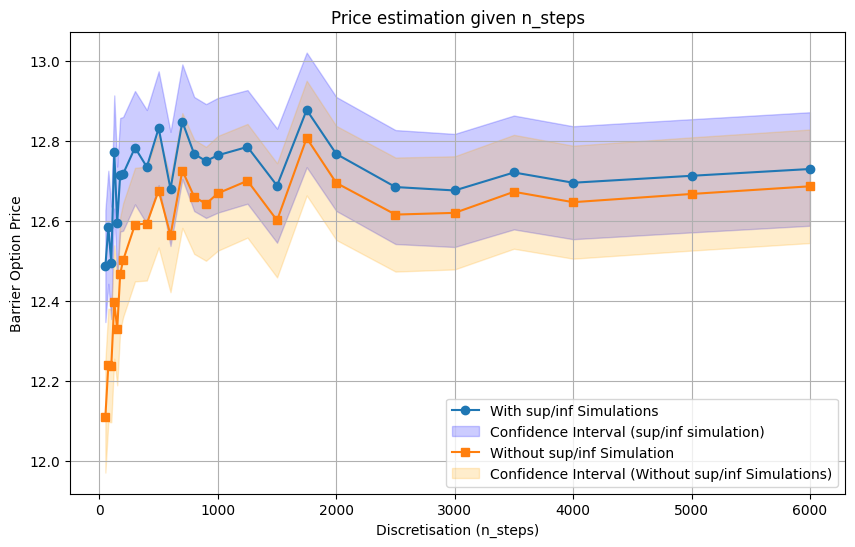

In [ ]:
prices_sim = np.array([prices for prices, IC in prices_with_simulation])
IC_sim = np.array([IC for prices, IC in prices_with_simulation])

prices_no_sim = np.array([prices for prices, IC in prices_without_simulation])
IC_no_sim = np.array([IC for prices, IC in prices_without_simulation])

plt.figure(figsize=(10, 6))

plt.plot(n_steps_list, prices_sim, label='With sup/inf Simulations', marker='o')
plt.fill_between(
    n_steps_list,
    prices_sim - IC_sim,
    prices_sim + IC_sim,
    alpha=0.2,
    color='blue',
    label='Confidence Interval (sup/inf simulation)'
)

plt.plot(n_steps_list, prices_no_sim, label='Without sup/inf Simulation', marker='s')
plt.fill_between(
    n_steps_list,
    prices_no_sim - IC_no_sim,
    prices_no_sim + IC_no_sim,
    alpha=0.2,
    color='orange',
    label='Confidence Interval (Without sup/inf Simulations)'
)

plt.xlabel('Discretisation (n_steps)')
plt.ylabel('Barrier Option Price')
plt.title('Price estimation given n_steps')
plt.legend()
plt.grid()
plt.show()


## Barrier options with Black and Schole model

In [ ]:
S = asset(S0 = 100,
          T = 1,
          r = 0.05,
          sigma = 0.3,
          )

## Up Barrier Options

Barrier Levels: 100%|██████████| 4/4 [03:09<00:00, 47.38s/it]


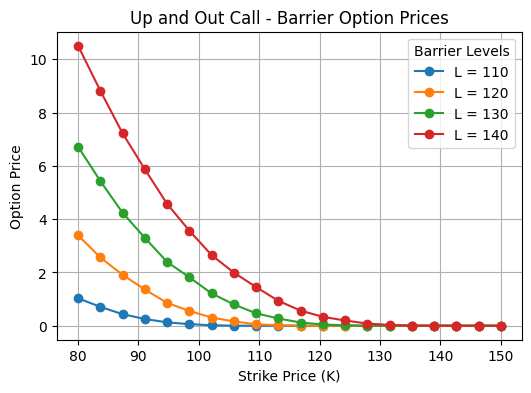

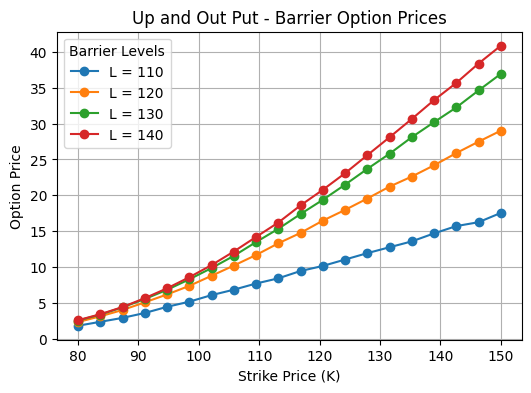

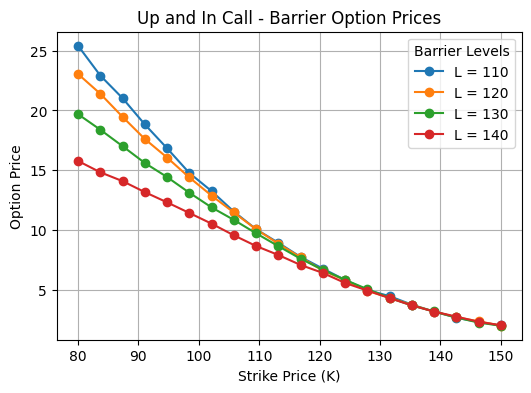

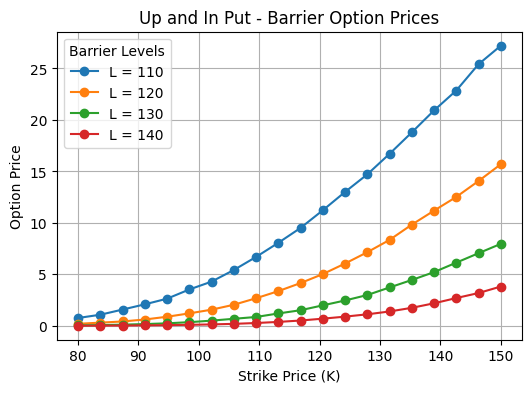

In [ ]:
K_values = np.linspace(80, 150, 20)
L_values = [110, 120, 130, 140]

barrier_up_prices = calculate_barrier_option_prices(S, K_values, L_values)
plot_prices(barrier_up_prices, K_values, L_values, up_down = 'Up')

## Down Barrier Options

Barrier Levels: 100%|██████████| 4/4 [03:06<00:00, 46.55s/it]


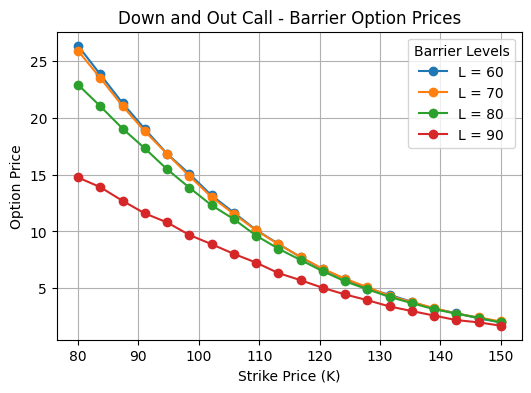

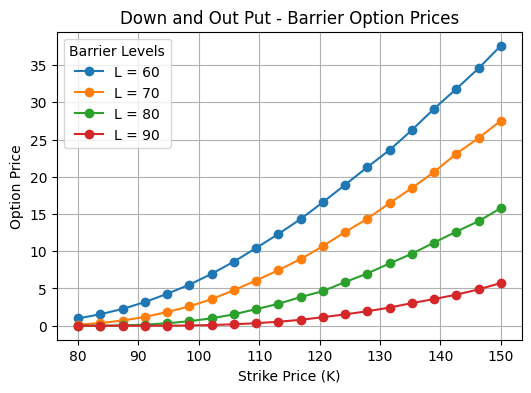

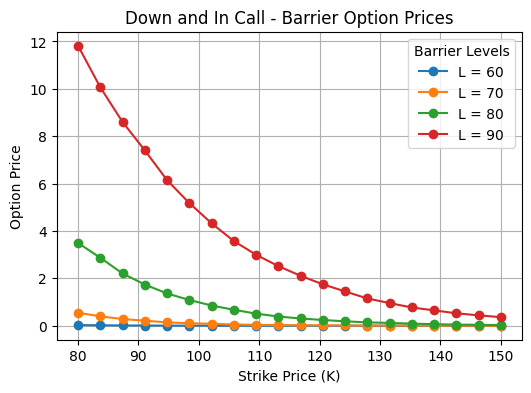

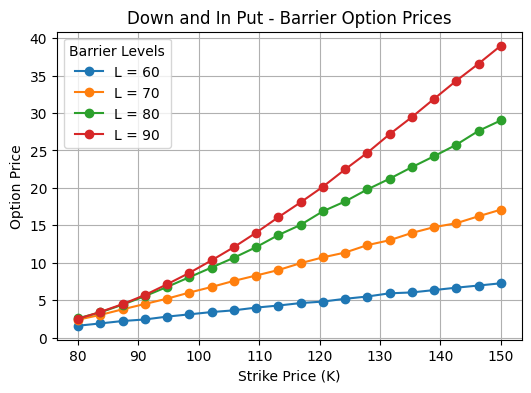

In [ ]:
K_values = np.linspace(80, 150, 20)
L_values = [60, 70, 80, 90]

barrier_down_prices = calculate_barrier_option_prices(K_values, L_values)
plot_prices(barrier_down_prices, up_down = 'Down')

## Barrier options with Heston model

In [ ]:
S = asset(S0 = 100,
          T = 1,
          r = 0.05,
          sigma = 0.3,
          kappa = 1.0,
          theta = 0.04,
          xi = 0.1,
          v0 = 0.04,
          rho = -0.7
          )

## Up Barrier Options

Barrier Levels: 100%|██████████| 4/4 [03:12<00:00, 48.04s/it]


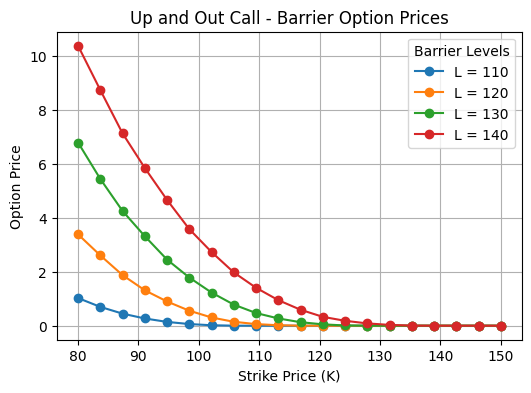

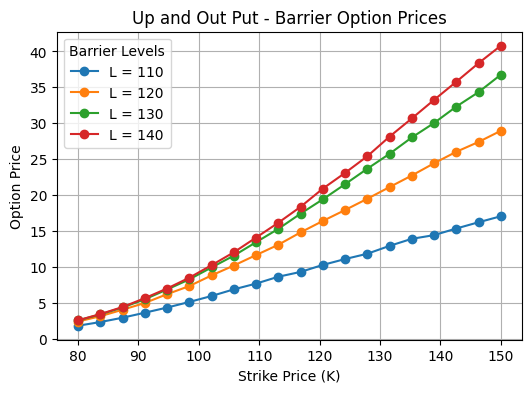

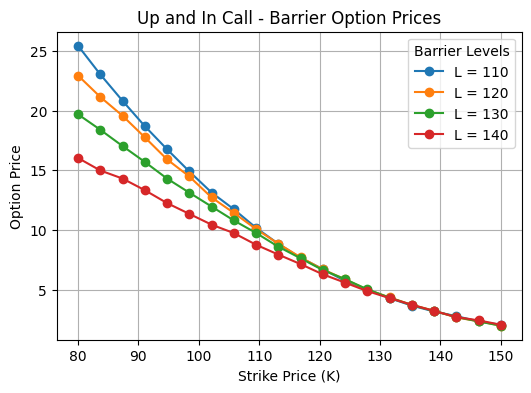

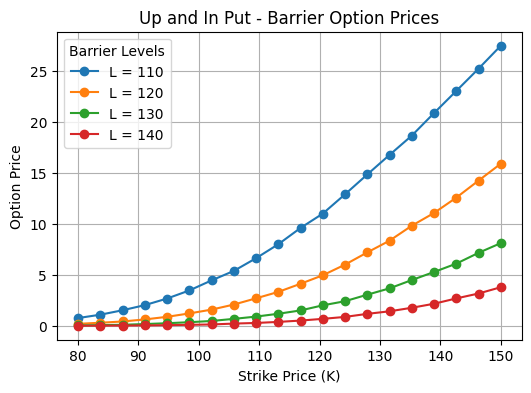

In [ ]:
K_values = np.linspace(80, 150, 20)
L_values = [110, 120, 130, 140]

barrier_up_prices = calculate_barrier_option_prices(S, K_values, L_values)
plot_prices(barrier_up_prices, up_down = 'Up')

## Down Barrier Options

Barrier Levels: 100%|██████████| 4/4 [03:08<00:00, 47.01s/it]


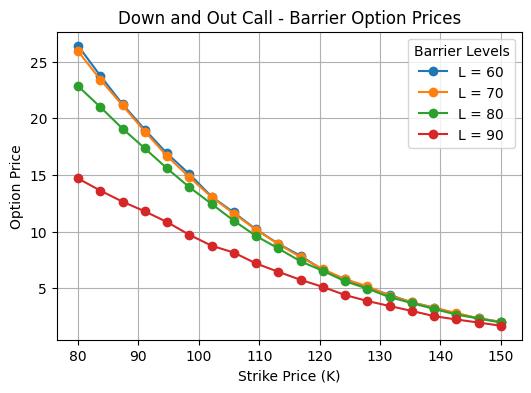

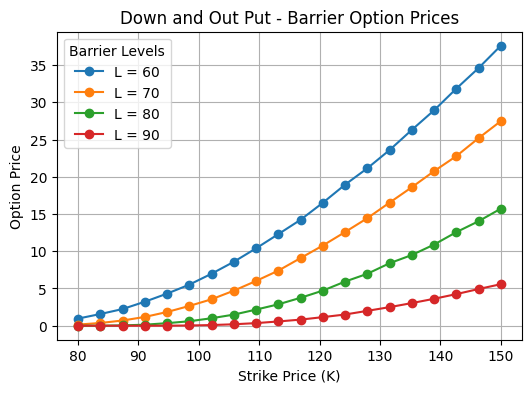

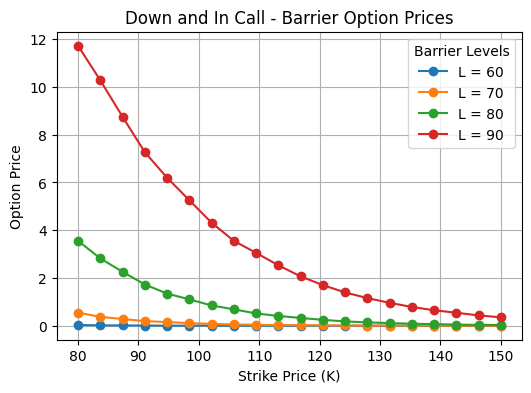

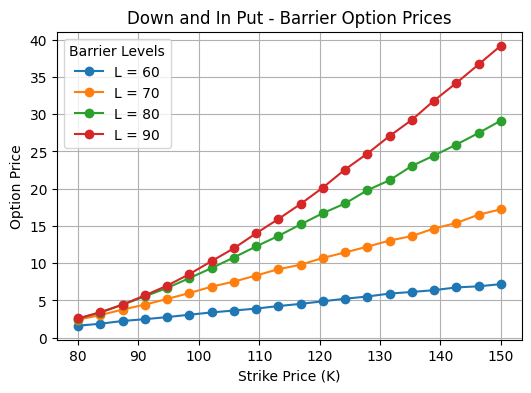

In [ ]:
K_values = np.linspace(80, 150, 20)
L_values = [60, 70, 80, 90]

barrier_down_prices = calculate_barrier_option_prices(S, K_values, L_values)
plot_prices(barrier_down_prices, up_down = 'Down')